In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xradar as xd
from xarray.backends.api import open_datatree
from dask.distributed import Client, LocalCluster

In [2]:
cluster = LocalCluster()

In [3]:
path_datatree = "D:/Alfonso/python/raw2zarr/zarr/Guaviare_V2.zarr"

In [4]:
radar_dtree = open_datatree(path_datatree, engine="zarr", chunks={})

In [5]:
radar_dtree

DataTree('None', parent=None)
│   Dimensions:              ()
│   Data variables:
│       altitude             float64 8B ...
│       instrument_type      <U5 20B ...
│       latitude             float64 8B ...
│       longitude            float64 8B ...
│       platform_type        <U5 20B ...
│       time_coverage_end    <U20 80B ...
│       time_coverage_start  <U20 80B ...
│       volume_number        int64 8B ...
│   Attributes:
│       Conventions:      None
│       comment:          im/exported using xradar
│       history:          None
│       institution:      None
│       instrument_name:  None
│       references:       None
│       source:           None
│       title:            None
│       version:          None
├── DataTree('radar_parameters')
│       Dimensions:    ()
│       Coordinates:
│           altitude   float64 8B ...
│           latitude   float64 8B ...
│           longitude  float64 8B ...
│       Data variables:
│           *empty*
├── DataTree('sweep_0')
│       Dimensions:            (vcp_time: 801, azimuth: 720, range: 994)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 3kB 0.25 0.75 1.25 ... 359.2 359.8
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           time               (azimuth) datetime64[ns] 6kB dask.array<chunksize=(720,), meta=np.ndarray>
│         * vcp_time           (vcp_time) datetime64[ns] 6kB 2022-06-04T00:00:30.1300...
│           x                  (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
│           y                  (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
│           z                  (azimuth, range) float32 3MB dask.array<chunksize=(180, 497), meta=np.ndarray>
│       Data variables: (12/17)
│           DBTH               (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DBZH               (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBTE8           (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_DBZE8           (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           DB_HCLASS          (vcp_time, azimuth, range) int16 1GB dask.array<chunksize=(1, 360, 497), meta=np.ndarray>
│           KDP                (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           ...                 ...
│           ZDR                (vcp_time, azimuth, range) float32 2GB dask.array<chunksize=(1, 180, 497), meta=np.ndarray>
│           follow_mode        (vcp_time) <U7 22kB dask.array<chunksize=(1,), meta=np.ndarray>
│           prt_mode           (vcp_time) <U7 22kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_fixed_angle  (vcp_time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_mode         (vcp_time) <U20 64kB dask.array<chunksize=(1,), meta=np.ndarray>
│           sweep_number       (vcp_time) int64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
├── DataTree('sweep_1')
│       Dimensions:            (vcp_time: 796, azimuth: 360, range: 747)
│       Coordinates:
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           crs_wkt            int64 8B ...
│           elevation          (azimuth) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
│           latitude           float64 8B ...
│           longitude          float64 8B ...
│         * range              (ran

In [6]:
print(f"radar datatree size: {radar_dtree.nbytes / (1024 ** 3)} GB")

radar datatree size: 99.72293827682734 GB


# Quasi-Vertical Profile (QVP)

In [7]:
ds_20deg = radar_dtree["sweep_9"].ds

In [8]:
%%time
qvp = 10 * np.log10((10 ** (ds_20deg.DBZH / 10)).mean("azimuth"))
qvp = qvp.assign_coords(
    range=(
        qvp.range.values
        / 1000
        * np.sin(ds_20deg.sweep_fixed_angle.mean(skipna=True).values * np.pi / 180.0)
    )
)

CPU times: total: 703 ms
Wall time: 550 ms


CPU times: total: 8.92 s
Wall time: 8.81 s


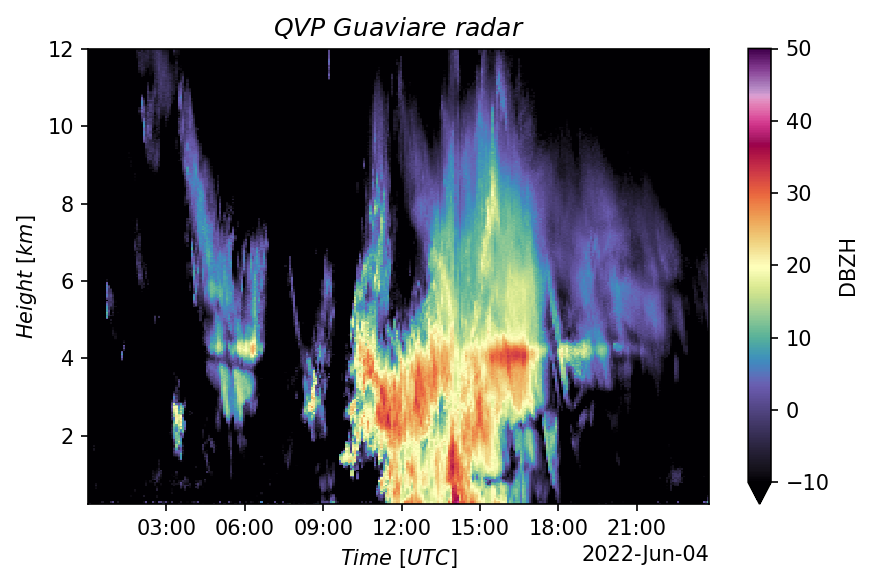

In [16]:
%%time
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
qvp.sel(range=slice(0, 12)).sel(vcp_time="2022-06-04").plot(
    x="vcp_time", y="range", cmap="ChaseSpectral", vmin=-10, vmax=50, ax=ax
)
ax.set_ylabel(r"$Height \ [km]$")
ax.set_xlabel(r"$Time \ [UTC]$")
ax.set_title(r"$QVP \ Guaviare \ radar$")
fig.tight_layout()
plt.savefig("../results/Guaviare_QVP.svg", bbox_inches="tight")

# Radar QPE

In [10]:
ds_05deg = radar_dtree["sweep_0"].ds

In [11]:
def rain_rate(z, a=200, b=1.6, dt=5):
    """
    Function that computes rain rate from the Marshall & Palmer (1948) relationship.
    This function also converts rain rates into rain depth by accumulating it at a
    given time delta
    """
    z_lin = 10 ** (z / 10)
    return ((1 / a) ** (1 / b) * z_lin ** (1 / b)) * (dt / 60)

In [12]:
%%time
rr_depth = rain_rate(z=ds_05deg.DBZH, a=250, b=1.2).sum("vcp_time").load()

CPU times: total: 24 s
Wall time: 7.41 s


C:\Users\ladin\anaconda3\envs\raw2zarr\Lib\site-packages\cartopy\mpl\geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


CPU times: total: 891 ms
Wall time: 845 ms


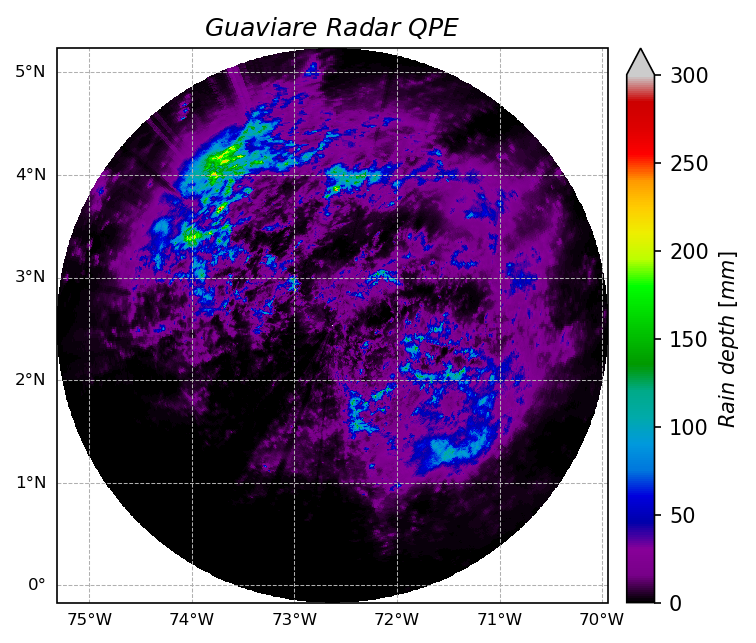

In [13]:
%%time
proj_crs = xd.georeference.get_crs(ds_05deg)
data_crs = ccrs.Projection(proj_crs)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, dpi=150)
rr_depth.plot(
    x="x",
    y="y",
    cmap="nipy_spectral",
    cbar_kwargs={
        "label": r"$Rain \ depth \  [mm]$",
        "pad": 0.025,
    },
    ax=ax,
    transform=data_crs,
    vmin=0,
    vmax=300,
)
gl = ax.gridlines(draw_labels=True, ls="--", lw=0.5)
gl.xlabel_style = {"size": 8}
gl.ylabel_style = {"size": 8}
ax.set_title(r"$Guaviare \ Radar \ QPE$")
gl.top_labels = False
gl.right_labels = False